## LSTM Sequence Model

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#시각화 생성 함수 : 주어진 시간(time)과 해당 시간에 대한 값 (series)를 기반으로 시계열 데이터 그래프 시각화 
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time #slope를 통해 추세의 기울기를 설정, 시간에 따라 선형적으로 증가하거나, 감소

#season_time를 사용한 계절의 패턴을 생성
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

# 전체 시간에 주기적인 패턴 생성 ( 시간,패턴반복주기,진폭,패턴의 시작점)
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)#랜덤 초기화
    return rnd.randn(len(time)) * noise_level #정규분포에 해당하는 랜덤 노이즈를 생성

In [13]:
#<< 훈련 데이터와 검증 데이터 세트로 분리하는 과정 >>

# 데이터 생성
time = np.arange(4 * 365 + 1, dtype="float32")
# baseline = 10
# series = trend(time, 0.1)  
baseline = 10 #시계열 데이터 기준값
amplitude = 40 #계절 성분 진폭
slope = 0.05 #시계열 데이터 기울기 (데이터 선형 추세)
noise_level = 5

#기준값 + 선형 추세 + 계절성으로 시계열 데이터 생성, 계절성 주기는 365
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
series += noise(time, noise_level, seed=42)

# 데이터 분할
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

(1461,) (1000,) (461,)


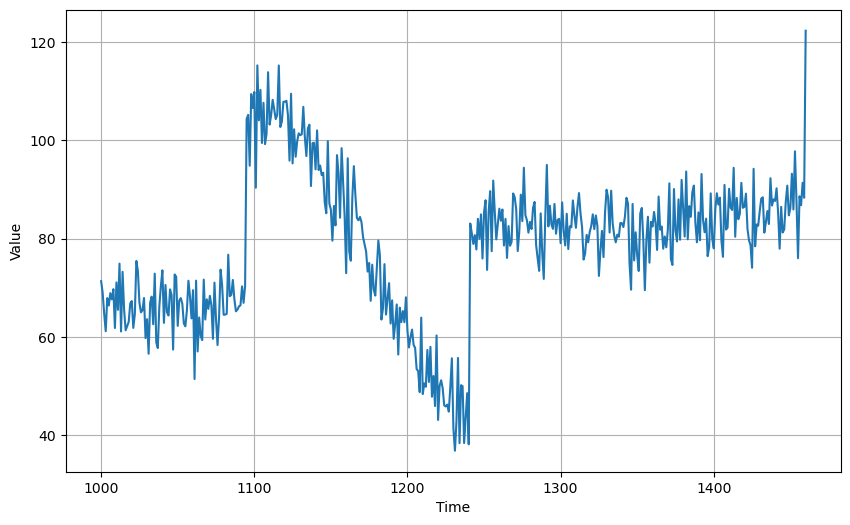

In [14]:
# 시각화 : 기후 데이터, 주식가격,웹사이트 트래픽,판매량등 특정기간 동안의 추세, 계절성,이상치등
# 1. 하락추세 2.변동성 3.평탄화구간 4.급격한 증가

print(series.shape,x_train.shape,x_valid.shape)

plt.figure(figsize=(10,6))
plot_series(time_valid,x_valid)

In [5]:
def windowed_dataset(series,window_size,batch_size,shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series) #시계열 데이터 배열을 데이터셋으로 변환
    
    #window_size + 1 = window_size = 과거 데이터 수, + 1 = 타겟 값 (예측할 다음값)
    dataset = dataset.window(window_size + 1,shift=1,drop_remainder=True) #윈도우 셋으로 변환
    
    # 데이터를 동일 크기의 배치로 만든다
    dataset = dataset.flat_map(lambda window:window.batch(window_size + 1))
    
    #데이터를 무작위로 썩는다.map을 통해서 타겟 레이블을 분리
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window:(window[:-1],window[-1]))
    
    #지정된 크기의 데이터셋 변환
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [6]:
# 학습한 세션을 클리어
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [7]:
# 모델 구현
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

dataset = windowed_dataset(x_train,window_size,batch_size,shuffle_buffer_size)

model = tf.keras.models.Sequential([
    # 1st Lambda Layer 2차원을 3차원으로 변환
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1),input_shape=[None]),
    
    # (input_dim + output_dim + 1) * output_dim * 4 = 2* ((1+32+1 )*32 * 4)
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=True)),
    
    # 2 * ((64+32+1)*32*4)
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    
    #(input_dim + 1) * output_dim = (64 + 1) * 1 = 65
    tf.keras.layers.Dense(1), #출력 레이어 
    
    tf.keras.layers.Lambda(lambda x:x*100.0) #모델의 출력을 위해 웒래 스케일로 되돌린다
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 bidirectional (Bidirection  (None, None, 64)          8704      
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                24832     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 33601 (131.25 KB)
Trainable params: 33601 